In [39]:
using JuMP

In [40]:
using PyPlot

## Generate data
Create some random values $x$ between 0 and 1, and then threshold them to create the correct outputs $y$. 

In [41]:
num_values = 10_000
x = rand(num_values,1)
true_threshold = 0.5
y = x .* (x .>= true_threshold)

10000x1 Array{Float64,2}:
 0.557174
 0.90923 
 0.861505
 0.0     
 0.966414
 0.0     
 0.0     
 0.0     
 0.811683
 0.0     
 0.0     
 0.0     
 0.0     
 ⋮       
 0.783921
 0.518234
 0.0     
 0.0     
 0.695443
 0.605943
 0.75449 
 0.95285 
 0.637856
 0.717191
 0.0     
 0.898006

## Set up the optimization
We'll search over polynomials of degree max_degree to find a good thresholding function. 

In [42]:
max_degree = 5
monomial_values = hcat([x .^ i for i = 0:max_degree]...)

m = Model()
@defVar(m, alpha[1:max_degree+1])
@defVar(m, yhat[1:num_values])
for j in 1:num_values
    @addConstraint(m, monomial_values[j,:] * alpha .== yhat[j])
end
@setObjective(m, Min, sum{(yhat[j] - y[j])^2, j=1:num_values})

:Min

## Solve it

In [43]:
@time status = solve(m)

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Optimize a model with 10000 rows, 10006 columns and 69968 nonzeros
Model has 10000 quadratic objective terms
Coefficient statistics:
  Matrix range    [1e-13, 1e+00]
  Objective range [1e+00, 2e+00]
  Bounds range    [0e+00, 0e+00]
  RHS range       [0e+00, 0e+00]
Presolve time: 0.02s
Presolved: 10000 rows, 10006 columns, 69968 nonzeros
Presolved model has 10000 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 6
 Free vars  : 10006
 AA' NZ     : 5.997e+04
 Factor NZ  : 6.999e+04 (roughly 9 MBytes of memory)
 Factor Ops : 4.897e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  0.00e+00 1.00e+00  0.00e+00     0s
   1  -2.85718171e+03 -2.85717599e+03  4.82e-14 1.00e-06  0.00e+00     0s
   2  -2.85718171e+03 -2.8

:Optimal

0.102419 seconds (155.09 k allocations: 10.163 MB, 3.01% gc time)


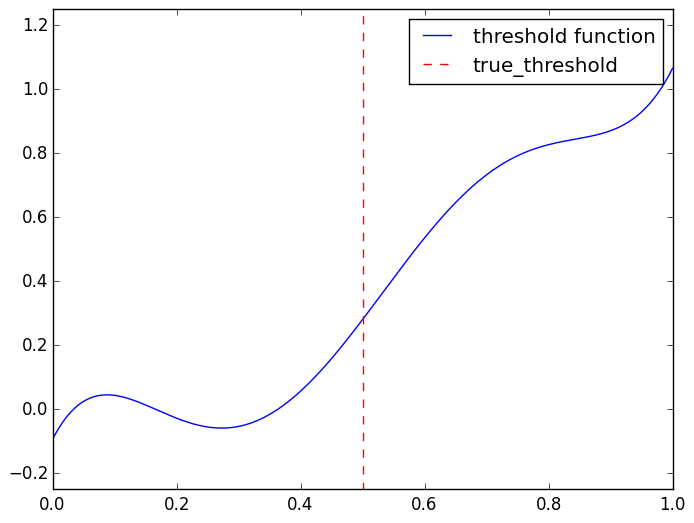

PyObject <matplotlib.legend.Legend object at 0x3186c6fd0>

In [44]:
function plot_performance(alpha, true_threshold)

    num_samples = 200
    xx = linspace(0, 1, num_samples)
    yy= zeros(num_samples)
    for j = 1:num_samples
        for k = 1:length(alpha)
            yy[j] += alpha[k] * xx[j] ^ (k - 1)
        end
    end
    plot(xx, yy)
    hold(true)
    plot([true_threshold, true_threshold], [-2, 2], "r--")
    ylim([-0.25, 1.25])
    legend(["threshold function", "true_threshold"])
end

alpha_qp = map(getValue, alpha)
plot_performance(alpha_qp, true_threshold)

## Solving it much faster
Actually, since this problem has no inequality constraints, we can solve it in closed form as a linear system:

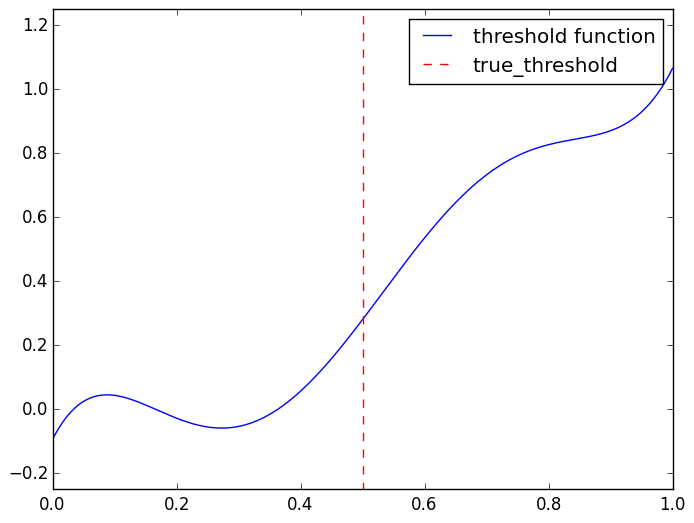

0.000016 seconds (14 allocations: 1.141 KB)


In [48]:
Q = zeros(max_degree+1, max_degree+1)
q = zeros(max_degree+1)

for i = 1:num_values
    v = [Float64(x[i,1] ^ j) for j = 0:max_degree]
    Q += v * v'
    q += -v * y[i]
end

@time alpha_ls = Q \ -q

plot_performance(alpha_ls, true_threshold)

@assert all(abs(alpha_ls - alpha_qp) .< 1e-6)